In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import calcu_lcoe
from shapely.geometry import Polygon
from Visual import MapViser
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np


In [2]:
valid_cell = gpd.read_file('./data/res/valid_cell.gpkg')

In [3]:
def create_concentric_rings_shp():
    max_radius_km = 30
    step_km = 1.0
    
    # --- 2. 定义中心点和坐标参考系 (CRS) ---
    # 同样使用等距方位投影，以确保距离的准确性。
    aeqd_crs = "+proj=aeqd +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    center_point = Point(0, 0)
    
    # --- 3. 循环生成环带几何图形 ---
    geometries = []
    attributes = []

    print(f"正在生成 0km 到 {max_radius_km}km 的同心环带...")

    # 循环定义每个环带的外圈半径
    for outer_radius_km in np.arange(0, max_radius_km + 1, step_km):
        # 计算内圈半径
        inner_radius_km = outer_radius_km - step_km
        
        # 将公里转换为米，以匹配CRS单位
        outer_radius_m = outer_radius_km * 1000
        inner_radius_m = inner_radius_km * 1000

        # 创建外圈圆
        outer_circle = center_point.buffer(outer_radius_m)
        
        # 如果内圈半径为0，则环带就是第一个实心圆
        if inner_radius_km == 0:
            ring = outer_circle
        else:
            # 创建内圈圆
            inner_circle = center_point.buffer(inner_radius_m)
            # 用外圆减去内圆，得到环带 (Donut)
            ring = outer_circle.difference(inner_circle)
        
        geometries.append(ring)
        # 为每个环带添加属性，方便识别
        attributes.append({
            'zone': f'{inner_radius_km}km - {outer_radius_km}km',
            'inner_km': inner_radius_km,
            'outer_km': outer_radius_km
        })

    # --- 4. 创建 GeoDataFrame ---
    # 将属性和几何图形合并
    gdf = gpd.GeoDataFrame(attributes, geometry=geometries, crs=aeqd_crs)
    
    return gdf

ring_gdf = create_concentric_rings_shp()

正在生成 0km 到 30km 的同心环带...


In [4]:
for i,r in ring_gdf.iterrows():
    dist = r['outer_km']
    tmp = valid_cell.loc[valid_cell['road_dist']<=dist]['equal_cap'].sum()
    ring_gdf.at[i,'equal_cap'] = tmp * 1e-3 #GW->TW


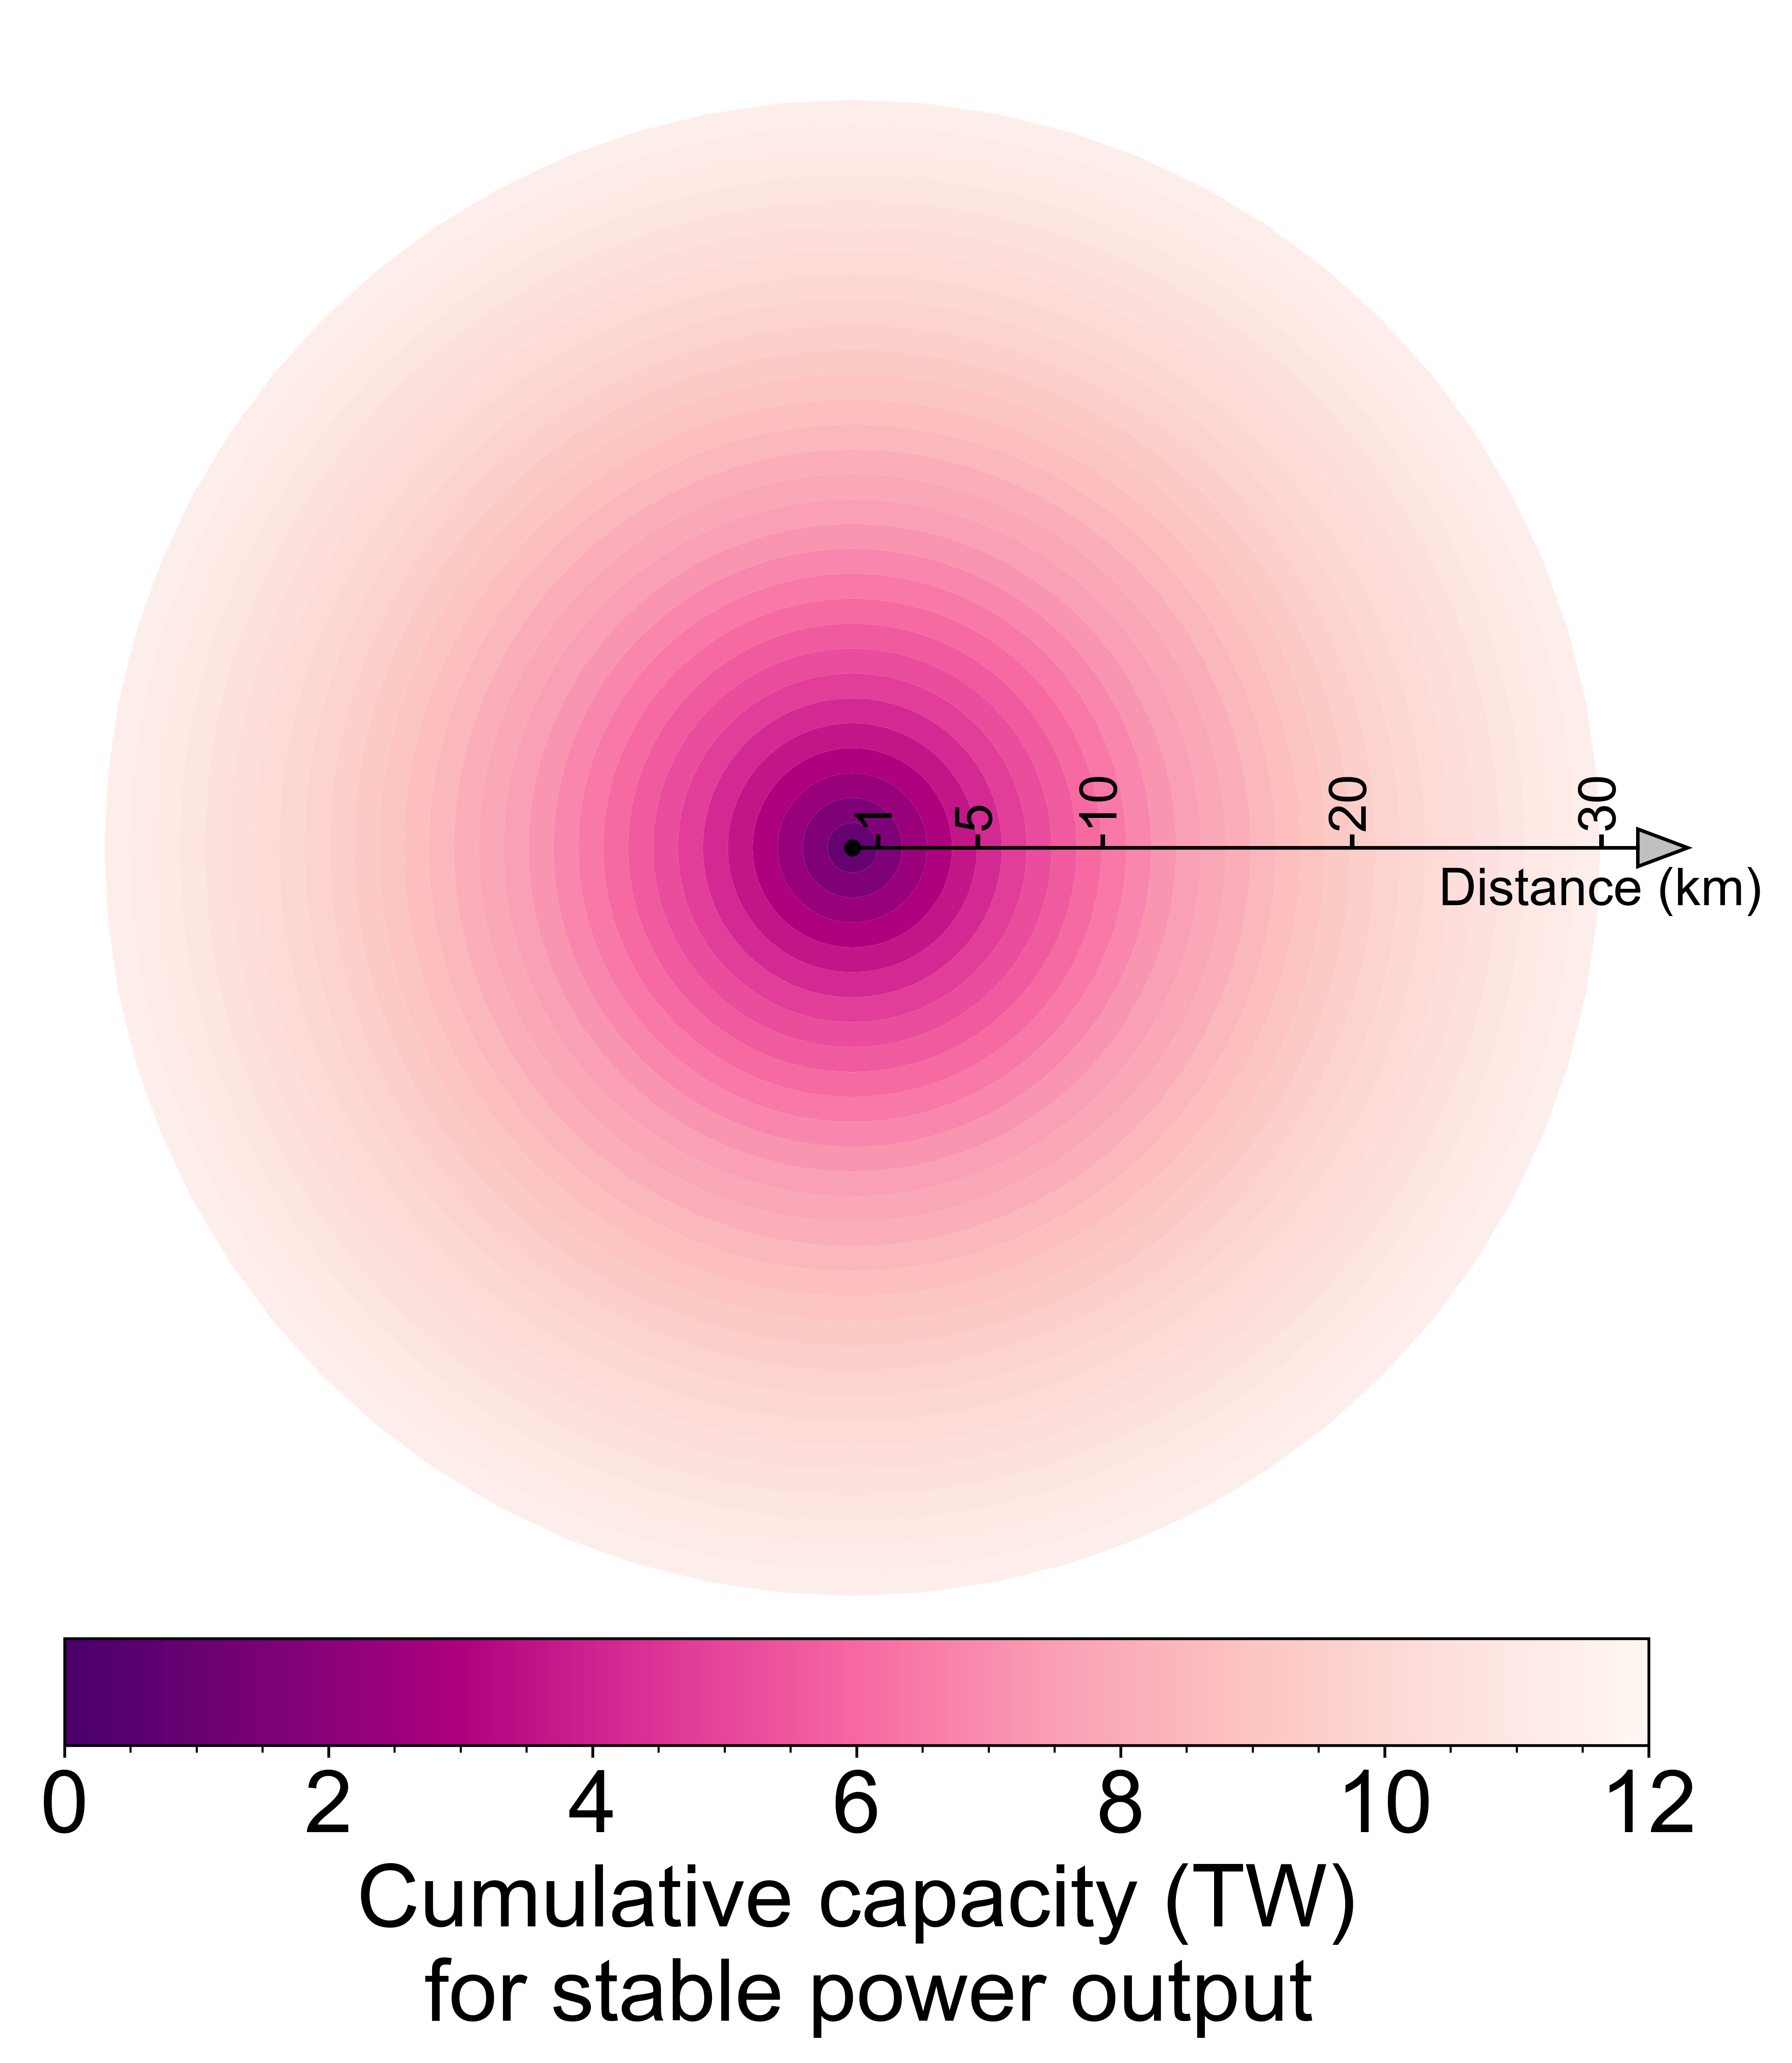

In [7]:
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.size'] = 25

cmap = 'RdPu_r'

fig,ax = plt.subplots(figsize=(12.6,8.5),dpi=600)


ring_gdf.loc[ring_gdf['outer_km']<=30].plot(ax=ax,
                                            column='equal_cap',
                                            cmap=cmap,
                                            vmax=12,
                                            edgecolor='none')

scatter = plt.scatter([0],[0],s=15,color='black')

cax = fig.add_axes([0.25,0.075,0.5,0.05])

im = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=12))
        
cbar = fig.colorbar(im,cax=cax,orientation='horizontal')

cax.minorticks_on()

cbar.set_label('Cumulative capacity (TW)\n for stable power output')

ax.axis('off')

ax.arrow(
    0.0,  
    0.0,  
    31500,  
    0.0, 
    head_width=1500,
    head_length=2000,
    facecolor='silver',
)

ax.text(x=30000,
        y=-1750,
        s='Distance (km)',
        ha='center',
        va='center',
        font={'size':15})

ax.text(x=1000,
        y=0,
        s='-1',
        ha='center',
        va='bottom',
        font={'size':15},
        rotation=90)

ax.text(x=5000,
        y=0,
        s='-5',
        ha='center',
        va='bottom',
        font={'size':15},
        rotation=90)

ax.text(x=10000,
        y=0,
        s='-10',
        ha='center',
        va='bottom',
        font={'size':15},
        rotation=90)

ax.text(x=20000,
        y=0,
        s='-20',
        ha='center',
        va='bottom',
        font={'size':15},
        rotation=90)

ax.text(x=30000,
        y=0,
        s='-30',
        ha='center',
        va='bottom',
        font={'size':15},
        rotation=90)

plt.savefig('./data/fig/Vis/road_dist_cap.png',bbox_inches='tight')